In [53]:
# %pip install torchsr

In [1]:
import pandas as pd
import torch 
from torchsr.models import ninasr_b0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sr_model = ninasr_b0(scale=2, pretrained=True)
sr_model.to(device);
sr_model.eval();

Downloading: "https://github.com/Coloquinte/torchSR/releases/download/v1.0.3/ninasr_b0_x2.pt" to /tmp/xdg_cache/torch/hub/checkpoints/ninasr_b0_x2.pt
100%|██████████| 408k/408k [00:02<00:00, 192kB/s] 


In [2]:
import os
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")

# Custom Dataset Class
class TreeDataset(Dataset):
    def __init__(self, dataframe, data_dir, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.data_dir = data_dir

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.dataframe.iloc[idx, 1])
        image = read_image(img_path)
        image = image / 255.0
        # print(image.shape, image.dtype)
        label = self.dataframe.iloc[idx, 0]
        # print(type(label))
        # print(label, img_path)
        # image = sr_model(image.to(device))[0]
        if self.transform:
            image = self.transform(image)

        return image, label

# Load the dataset
def load_data(csv_file):
    df = pd.read_csv(csv_file, sep='\t')
    df[df.columns[1]] = df[df.columns[1]].map(lambda name: name.split('/')[-1])
    return df
    # return train_test_split(df, test_size=0.2, random_state=42)

# Training and Validation Function
def train_model(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=10, loss_dct={}):
    
    model.to(device)

    # pb = tqdm()
    for epoch in range(num_epochs):
        # phase
        pb_text = f'Epoch: {epoch}/{num_epochs - 1} ||'
        # print(f'Epoch {epoch}/{num_epochs - 1}')
        # print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.argmax(torch.sigmoid(outputs), dim=-1)
                    # print(outputs.shape, labels.shape)
                    loss = criterion(outputs, labels.to(dtype=torch.long))

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds.view(-1) == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            if scheduler is not None:
                scheduler.step(epoch_loss)
                    
            
            pb_text += f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} ||'
            loss_dct[phase]['loss'].append(epoch_loss)
            loss_dct[phase]['acc'].append(epoch_acc)
        print(pb_text)
        # pb.set_description(pb_text)
    return model, loss_dct

DATA_DIR = "data/gt_images"
val_df = load_data('data/hw_3_markup_data.txt')
# train_df = load_data('data/train_data.txt')
train_df = load_data('data/train_data_new.txt')

# Define transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomAdjustSharpness(2),
    transforms.RandomAutocontrast(),
    # transforms.GaussianBlur(3),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



# Create datasets and dataloaders
train_dataset = TreeDataset(train_df, data_dir=DATA_DIR, transform=train_transform)
val_dataset = TreeDataset(val_df, data_dir=DATA_DIR, transform=val_transform)

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, pin_memory_device='cuda'),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True),
}
# model = models.resnet18(pretrained=True)
model = models.efficientnet_b4(weights='IMAGENET1K_V1')
# for param in model.parameters():
#     param.requires_grad = False
    
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)  # For binary classification
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)
# scheduler = None
# Train the model

loss_dct = {
        "train": {
            "loss": [],
            "acc": []
        },
        "val": {
            "loss": [],
            "acc": []
        },
    }
trained_model, _ = train_model(model, dataloaders, criterion, optimizer, scheduler=scheduler, num_epochs=100, loss_dct=loss_dct)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /tmp/xdg_cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth
100%|██████████| 74.5M/74.5M [00:02<00:00, 34.9MB/s]
100%|██████████| 7/7 [00:01<00:00,  6.51it/s]


Epoch: 0/99 ||train Loss: 0.6415 Acc: 0.6465 ||val Loss: 0.6448 Acc: 0.5700 ||


100%|██████████| 7/7 [00:00<00:00, 10.50it/s]


Epoch: 1/99 ||train Loss: 0.5671 Acc: 0.6985 ||val Loss: 0.5589 Acc: 0.6700 ||


100%|██████████| 7/7 [00:00<00:00, 12.45it/s]


Epoch: 2/99 ||train Loss: 0.5167 Acc: 0.7482 ||val Loss: 0.4900 Acc: 0.7200 ||


100%|██████████| 7/7 [00:00<00:00, 12.49it/s]


Epoch: 3/99 ||train Loss: 0.4921 Acc: 0.7651 ||val Loss: 0.4274 Acc: 0.7950 ||


100%|██████████| 7/7 [00:00<00:00, 12.50it/s]


Epoch: 4/99 ||train Loss: 0.4547 Acc: 0.7804 ||val Loss: 0.3979 Acc: 0.7900 ||


100%|██████████| 7/7 [00:00<00:00, 12.13it/s]


Epoch: 5/99 ||train Loss: 0.4564 Acc: 0.7899 ||val Loss: 0.3934 Acc: 0.8150 ||


100%|██████████| 7/7 [00:00<00:00, 12.15it/s]


Epoch: 6/99 ||train Loss: 0.4304 Acc: 0.7826 ||val Loss: 0.3577 Acc: 0.8200 ||


100%|██████████| 7/7 [00:00<00:00, 12.38it/s]


Epoch: 7/99 ||train Loss: 0.4343 Acc: 0.7945 ||val Loss: 0.3736 Acc: 0.7950 ||


100%|██████████| 7/7 [00:00<00:00, 12.52it/s]


Epoch: 8/99 ||train Loss: 0.4161 Acc: 0.8069 ||val Loss: 0.3792 Acc: 0.8250 ||


100%|██████████| 7/7 [00:00<00:00, 11.87it/s]


Epoch: 9/99 ||train Loss: 0.4119 Acc: 0.8091 ||val Loss: 0.3607 Acc: 0.8200 ||


100%|██████████| 7/7 [00:00<00:00, 12.45it/s]


Epoch: 10/99 ||train Loss: 0.3859 Acc: 0.8267 ||val Loss: 0.3614 Acc: 0.8100 ||


100%|██████████| 7/7 [00:00<00:00, 12.74it/s]


Epoch: 11/99 ||train Loss: 0.3811 Acc: 0.8289 ||val Loss: 0.3538 Acc: 0.8300 ||


100%|██████████| 7/7 [00:00<00:00, 12.43it/s]


Epoch: 12/99 ||train Loss: 0.3862 Acc: 0.8261 ||val Loss: 0.3441 Acc: 0.8350 ||


100%|██████████| 7/7 [00:00<00:00, 12.01it/s]


Epoch: 13/99 ||train Loss: 0.3705 Acc: 0.8283 ||val Loss: 0.3425 Acc: 0.8200 ||


100%|██████████| 7/7 [00:00<00:00, 12.51it/s]


Epoch: 14/99 ||train Loss: 0.3629 Acc: 0.8402 ||val Loss: 0.3384 Acc: 0.8200 ||


100%|██████████| 7/7 [00:00<00:00, 11.63it/s]


Epoch: 15/99 ||train Loss: 0.3678 Acc: 0.8300 ||val Loss: 0.3394 Acc: 0.8350 ||


100%|██████████| 7/7 [00:00<00:00, 12.58it/s]


Epoch: 16/99 ||train Loss: 0.3758 Acc: 0.8379 ||val Loss: 0.3438 Acc: 0.8400 ||


100%|██████████| 7/7 [00:00<00:00, 11.62it/s]


Epoch: 17/99 ||train Loss: 0.3638 Acc: 0.8430 ||val Loss: 0.3429 Acc: 0.8200 ||


100%|██████████| 7/7 [00:00<00:00, 12.00it/s]


Epoch: 18/99 ||train Loss: 0.3691 Acc: 0.8374 ||val Loss: 0.3326 Acc: 0.8250 ||


100%|██████████| 7/7 [00:00<00:00, 12.10it/s]


Epoch: 19/99 ||train Loss: 0.3543 Acc: 0.8419 ||val Loss: 0.3309 Acc: 0.8300 ||


100%|██████████| 7/7 [00:00<00:00, 12.36it/s]


Epoch: 20/99 ||train Loss: 0.3600 Acc: 0.8453 ||val Loss: 0.3310 Acc: 0.8300 ||


100%|██████████| 7/7 [00:00<00:00, 12.02it/s]


Epoch: 21/99 ||train Loss: 0.3624 Acc: 0.8346 ||val Loss: 0.3312 Acc: 0.8300 ||


100%|██████████| 7/7 [00:00<00:00, 11.66it/s]


Epoch: 22/99 ||train Loss: 0.3676 Acc: 0.8278 ||val Loss: 0.3312 Acc: 0.8300 ||


100%|██████████| 7/7 [00:00<00:00, 12.68it/s]


Epoch: 23/99 ||train Loss: 0.3609 Acc: 0.8402 ||val Loss: 0.3345 Acc: 0.8300 ||


100%|██████████| 7/7 [00:00<00:00, 12.18it/s]


Epoch: 24/99 ||train Loss: 0.3538 Acc: 0.8453 ||val Loss: 0.3300 Acc: 0.8350 ||


100%|██████████| 7/7 [00:00<00:00, 12.64it/s]


Epoch: 25/99 ||train Loss: 0.3564 Acc: 0.8351 ||val Loss: 0.3251 Acc: 0.8450 ||


100%|██████████| 7/7 [00:00<00:00, 12.21it/s]


Epoch: 26/99 ||train Loss: 0.3598 Acc: 0.8374 ||val Loss: 0.3303 Acc: 0.8300 ||


100%|██████████| 7/7 [00:00<00:00, 12.35it/s]


Epoch: 27/99 ||train Loss: 0.3681 Acc: 0.8295 ||val Loss: 0.3362 Acc: 0.8300 ||


100%|██████████| 7/7 [00:00<00:00, 12.28it/s]


Epoch: 28/99 ||train Loss: 0.3764 Acc: 0.8272 ||val Loss: 0.3280 Acc: 0.8250 ||


100%|██████████| 7/7 [00:00<00:00, 12.43it/s]


Epoch: 29/99 ||train Loss: 0.3502 Acc: 0.8402 ||val Loss: 0.3322 Acc: 0.8300 ||


100%|██████████| 7/7 [00:00<00:00, 12.36it/s]


Epoch: 30/99 ||train Loss: 0.3505 Acc: 0.8430 ||val Loss: 0.3287 Acc: 0.8400 ||


100%|██████████| 7/7 [00:00<00:00, 12.57it/s]


Epoch: 31/99 ||train Loss: 0.3438 Acc: 0.8425 ||val Loss: 0.3313 Acc: 0.8350 ||


100%|██████████| 7/7 [00:00<00:00, 12.75it/s]


Epoch: 32/99 ||train Loss: 0.3594 Acc: 0.8396 ||val Loss: 0.3286 Acc: 0.8250 ||


100%|██████████| 7/7 [00:00<00:00, 12.37it/s]


Epoch: 33/99 ||train Loss: 0.3564 Acc: 0.8323 ||val Loss: 0.3364 Acc: 0.8100 ||


100%|██████████| 7/7 [00:00<00:00, 12.19it/s]


Epoch: 34/99 ||train Loss: 0.3465 Acc: 0.8402 ||val Loss: 0.3302 Acc: 0.8300 ||


100%|██████████| 7/7 [00:00<00:00, 12.08it/s]


Epoch: 35/99 ||train Loss: 0.3598 Acc: 0.8363 ||val Loss: 0.3251 Acc: 0.8450 ||


100%|██████████| 7/7 [00:00<00:00, 12.74it/s]


Epoch: 36/99 ||train Loss: 0.3550 Acc: 0.8385 ||val Loss: 0.3373 Acc: 0.8250 ||


100%|██████████| 7/7 [00:00<00:00, 12.13it/s]


Epoch: 37/99 ||train Loss: 0.3582 Acc: 0.8408 ||val Loss: 0.3309 Acc: 0.8350 ||


100%|██████████| 7/7 [00:00<00:00, 12.05it/s]


Epoch: 38/99 ||train Loss: 0.3487 Acc: 0.8413 ||val Loss: 0.3325 Acc: 0.8300 ||


100%|██████████| 7/7 [00:00<00:00, 12.65it/s]


Epoch: 39/99 ||train Loss: 0.3497 Acc: 0.8458 ||val Loss: 0.3239 Acc: 0.8450 ||


100%|██████████| 7/7 [00:00<00:00, 12.22it/s]


Epoch: 40/99 ||train Loss: 0.3550 Acc: 0.8396 ||val Loss: 0.3347 Acc: 0.8250 ||


100%|██████████| 7/7 [00:00<00:00, 12.74it/s]


Epoch: 41/99 ||train Loss: 0.3636 Acc: 0.8278 ||val Loss: 0.3271 Acc: 0.8350 ||


100%|██████████| 7/7 [00:00<00:00, 12.69it/s]


Epoch: 42/99 ||train Loss: 0.3443 Acc: 0.8509 ||val Loss: 0.3275 Acc: 0.8400 ||


100%|██████████| 7/7 [00:00<00:00, 12.77it/s]


Epoch: 43/99 ||train Loss: 0.3487 Acc: 0.8425 ||val Loss: 0.3298 Acc: 0.8250 ||


100%|██████████| 7/7 [00:00<00:00, 11.73it/s]


Epoch: 44/99 ||train Loss: 0.3534 Acc: 0.8413 ||val Loss: 0.3331 Acc: 0.8200 ||


100%|██████████| 7/7 [00:00<00:00, 11.88it/s]


Epoch: 45/99 ||train Loss: 0.3709 Acc: 0.8295 ||val Loss: 0.3255 Acc: 0.8400 ||


100%|██████████| 7/7 [00:00<00:00, 12.13it/s]


Epoch: 46/99 ||train Loss: 0.3623 Acc: 0.8323 ||val Loss: 0.3318 Acc: 0.8350 ||


100%|██████████| 7/7 [00:00<00:00, 12.53it/s]


Epoch: 47/99 ||train Loss: 0.3627 Acc: 0.8408 ||val Loss: 0.3339 Acc: 0.8300 ||


100%|██████████| 7/7 [00:00<00:00, 12.63it/s]


Epoch: 48/99 ||train Loss: 0.3670 Acc: 0.8272 ||val Loss: 0.3336 Acc: 0.8300 ||


100%|██████████| 7/7 [00:00<00:00, 12.83it/s]


Epoch: 49/99 ||train Loss: 0.3649 Acc: 0.8346 ||val Loss: 0.3271 Acc: 0.8350 ||


100%|██████████| 7/7 [00:00<00:00, 11.49it/s]


Epoch: 50/99 ||train Loss: 0.3533 Acc: 0.8425 ||val Loss: 0.3288 Acc: 0.8350 ||


100%|██████████| 7/7 [00:00<00:00, 12.67it/s]


Epoch: 51/99 ||train Loss: 0.3684 Acc: 0.8238 ||val Loss: 0.3324 Acc: 0.8350 ||


100%|██████████| 7/7 [00:00<00:00, 12.55it/s]


Epoch: 52/99 ||train Loss: 0.3568 Acc: 0.8453 ||val Loss: 0.3367 Acc: 0.8250 ||


100%|██████████| 7/7 [00:00<00:00, 11.87it/s]


Epoch: 53/99 ||train Loss: 0.3634 Acc: 0.8368 ||val Loss: 0.3235 Acc: 0.8350 ||


100%|██████████| 7/7 [00:00<00:00, 12.47it/s]


Epoch: 54/99 ||train Loss: 0.3705 Acc: 0.8238 ||val Loss: 0.3341 Acc: 0.8450 ||


100%|██████████| 7/7 [00:00<00:00, 11.84it/s]


Epoch: 55/99 ||train Loss: 0.3630 Acc: 0.8357 ||val Loss: 0.3276 Acc: 0.8350 ||


100%|██████████| 7/7 [00:00<00:00, 12.74it/s]


Epoch: 56/99 ||train Loss: 0.3461 Acc: 0.8430 ||val Loss: 0.3288 Acc: 0.8250 ||


100%|██████████| 7/7 [00:00<00:00, 12.86it/s]


Epoch: 57/99 ||train Loss: 0.3697 Acc: 0.8323 ||val Loss: 0.3299 Acc: 0.8350 ||


100%|██████████| 7/7 [00:00<00:00, 12.71it/s]


Epoch: 58/99 ||train Loss: 0.3722 Acc: 0.8289 ||val Loss: 0.3313 Acc: 0.8300 ||


100%|██████████| 7/7 [00:00<00:00, 12.11it/s]


Epoch: 59/99 ||train Loss: 0.3542 Acc: 0.8346 ||val Loss: 0.3313 Acc: 0.8350 ||


100%|██████████| 7/7 [00:00<00:00, 12.67it/s]


Epoch: 60/99 ||train Loss: 0.3440 Acc: 0.8470 ||val Loss: 0.3293 Acc: 0.8400 ||


100%|██████████| 7/7 [00:00<00:00, 12.77it/s]


Epoch: 61/99 ||train Loss: 0.3688 Acc: 0.8300 ||val Loss: 0.3356 Acc: 0.8250 ||


100%|██████████| 7/7 [00:00<00:00, 12.61it/s]


Epoch: 62/99 ||train Loss: 0.3603 Acc: 0.8312 ||val Loss: 0.3314 Acc: 0.8300 ||


100%|██████████| 7/7 [00:00<00:00, 12.49it/s]


Epoch: 63/99 ||train Loss: 0.3483 Acc: 0.8442 ||val Loss: 0.3326 Acc: 0.8350 ||


100%|██████████| 7/7 [00:00<00:00, 12.76it/s]


Epoch: 64/99 ||train Loss: 0.3720 Acc: 0.8255 ||val Loss: 0.3334 Acc: 0.8400 ||


100%|██████████| 7/7 [00:00<00:00, 12.83it/s]


Epoch: 65/99 ||train Loss: 0.3607 Acc: 0.8323 ||val Loss: 0.3347 Acc: 0.8300 ||


100%|██████████| 7/7 [00:00<00:00, 12.79it/s]


Epoch: 66/99 ||train Loss: 0.3559 Acc: 0.8340 ||val Loss: 0.3264 Acc: 0.8350 ||


100%|██████████| 7/7 [00:00<00:00, 12.65it/s]


Epoch: 67/99 ||train Loss: 0.3522 Acc: 0.8430 ||val Loss: 0.3257 Acc: 0.8400 ||


100%|██████████| 7/7 [00:00<00:00, 12.83it/s]


Epoch: 68/99 ||train Loss: 0.3573 Acc: 0.8408 ||val Loss: 0.3355 Acc: 0.8350 ||


100%|██████████| 7/7 [00:00<00:00, 11.79it/s]


Epoch: 69/99 ||train Loss: 0.3732 Acc: 0.8250 ||val Loss: 0.3335 Acc: 0.8350 ||


100%|██████████| 7/7 [00:00<00:00, 12.26it/s]


Epoch: 70/99 ||train Loss: 0.3658 Acc: 0.8385 ||val Loss: 0.3349 Acc: 0.8300 ||


100%|██████████| 7/7 [00:00<00:00, 12.82it/s]


Epoch: 71/99 ||train Loss: 0.3687 Acc: 0.8289 ||val Loss: 0.3249 Acc: 0.8450 ||


100%|██████████| 7/7 [00:00<00:00, 12.20it/s]


Epoch: 72/99 ||train Loss: 0.3596 Acc: 0.8300 ||val Loss: 0.3289 Acc: 0.8450 ||


100%|██████████| 7/7 [00:00<00:00, 11.75it/s]


Epoch: 73/99 ||train Loss: 0.3535 Acc: 0.8419 ||val Loss: 0.3348 Acc: 0.8350 ||


100%|██████████| 7/7 [00:00<00:00, 12.67it/s]


Epoch: 74/99 ||train Loss: 0.3630 Acc: 0.8402 ||val Loss: 0.3281 Acc: 0.8400 ||


100%|██████████| 7/7 [00:00<00:00, 12.76it/s]


Epoch: 75/99 ||train Loss: 0.3591 Acc: 0.8402 ||val Loss: 0.3279 Acc: 0.8350 ||


100%|██████████| 7/7 [00:00<00:00, 12.73it/s]


Epoch: 76/99 ||train Loss: 0.3522 Acc: 0.8458 ||val Loss: 0.3352 Acc: 0.8350 ||


100%|██████████| 7/7 [00:00<00:00, 11.73it/s]


Epoch: 77/99 ||train Loss: 0.3526 Acc: 0.8368 ||val Loss: 0.3312 Acc: 0.8300 ||


100%|██████████| 7/7 [00:00<00:00, 12.52it/s]


Epoch: 78/99 ||train Loss: 0.3466 Acc: 0.8402 ||val Loss: 0.3315 Acc: 0.8250 ||


100%|██████████| 7/7 [00:00<00:00, 12.88it/s]


Epoch: 79/99 ||train Loss: 0.3477 Acc: 0.8458 ||val Loss: 0.3329 Acc: 0.8200 ||


100%|██████████| 7/7 [00:00<00:00, 12.81it/s]


Epoch: 80/99 ||train Loss: 0.3666 Acc: 0.8334 ||val Loss: 0.3326 Acc: 0.8350 ||


 25%|██▌       | 14/56 [00:04<00:12,  3.39it/s]


KeyboardInterrupt: 

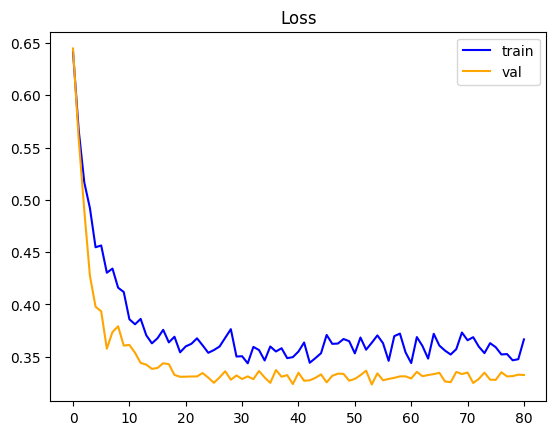

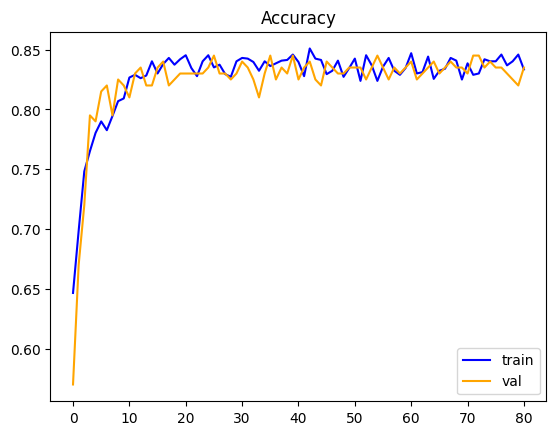

In [3]:
import matplotlib.pyplot as plt
import numpy as np
plt.plot(loss_dct['train']['loss'], color='b', label='train')
plt.plot(loss_dct['val']['loss'], color='orange', label='val')
plt.title("Loss")
plt.legend()
plt.show()

plt.plot(np.array([acc.cpu() for acc in loss_dct['train']['acc']]), color='b', label='train')
plt.plot(np.array([acc.cpu() for acc in loss_dct['val']['acc']]), color='orange', label='val')
plt.title("Accuracy")
plt.legend()
plt.show()

In [5]:
# torch.save()
# trained_model.
checkpoint_path = "ckpt/eff_b3_augs_new.pth"
torch.save(model.state_dict(), checkpoint_path)

In [41]:
# trained_model[0]

In [49]:
# state_dict = torch.load("ckpt/eff_b3_augs.pth")
# trained_model.load_state_dict(state_dict)

<All keys matched successfully>

In [6]:
def load_test_data(path):
    data = pd.read_excel(path)
    return data

test_df = load_test_data('data/test_set_for_labeling.xlsx')
test_df.head(10)

,downloadUrl
0,https://new-projects-team-public.s3.yandex.net...
1,https://new-projects-team-public.s3.yandex.net...
2,https://new-projects-team-public.s3.yandex.net...
3,https://new-projects-team-public.s3.yandex.net...
4,https://new-projects-team-public.s3.yandex.net...
5,https://new-projects-team-public.s3.yandex.net...
6,https://new-projects-team-public.s3.yandex.net...
7,https://new-projects-team-public.s3.yandex.net...
8,https://new-projects-team-public.s3.yandex.net...
9,https://new-projects-team-public.s3.yandex.net...


In [10]:
class TreeTestDataset(Dataset):
    def __init__(self, dataframe, data_dir, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.data_dir = data_dir

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.dataframe.iloc[idx, 0].split('/')[-1])
        image = read_image(img_path)
        image = image / 255.0
        # print(image.shape, image.dtype)
        # label = self.dataframe.iloc[idx, 0]
        # print(type(label))
        # print(label, img_path)
        # image = sr_model(image.to(device))[0]
        if self.transform:
            image = self.transform(image)

        return image, self.dataframe.iloc[idx, 0]

test_dataset = TreeTestDataset(test_df, data_dir="data/test_images", transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True, pin_memory_device='cuda')
predictions = []
img_paths = []
for inputs, paths in tqdm(test_loader):
    inputs = inputs.to(device)
    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        preds = torch.argmax(torch.sigmoid(outputs), dim=-1).cpu().numpy()
        predictions.extend(preds)
        img_paths.extend(paths)
        
header = "downloadUrl,is_conifer\n"
text_data = header + '\n'.join([f"{url},{str(bool(label)).upper()}" for url, label in zip(img_paths, predictions)])
# text_data
with open("data/test_result_labels.txt", 'w') as f:
    f.write(text_data)